In [1]:
%matplotlib inline
# %matplotlib notebook

try:
    from importlib import reload
except:
    pass

from __future__ import print_function ## Force python3-like printing

import os

from matplotlib import pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

import sfdmap

import numpy as np
from astropy.table import Table,Column

import pycoco as pcc

reload(pcc) ## FOR DEV
# reload(pcc.defaults)
# reload(pcc.functions)
# reload(pcc.classes)
# reload(pcc.utils)


import pyCoCo as pccsims

In [2]:
pccsims.__file__

'/Users/berto/Code/CoCo/pyCoCo.cpython-36m-darwin.so'

In [3]:
def convert_column_string_encoding(column):
    column = Column([pcc.utils.b(x) for x in column.data], name = column.name)
    return column

def get_mjdmax_BessellV(sn):
    v = sn.lcfit.spline["BessellV"]    
    mjd_spline = np.arange(np.nanmin(sn.phot.data["BessellV"]["MJD"]), 
                 np.nanmax(sn.phot.data["BessellV"]["MJD"]),
                 0.001)
    w = np.where(v(mjd_spline) == np.nanmax(v(mjd_spline)))

    mjdmax = mjd_spline[w]
    
    return mjdmax

In [4]:
filter_path = pcc._default_filter_dir_path
coco_root_path = pcc._default_coco_dir_path

reload(pccsims)
coco = pccsims.pyCoCo(pcc.utils.b(filter_path), pcc.utils.b(coco_root_path))

Load in an templates object 

/Users/berto/Code/CoCo/data/lc/SN2007uy.dat
/Users/berto/Code/CoCo/data/lc/SN2007uy.dat


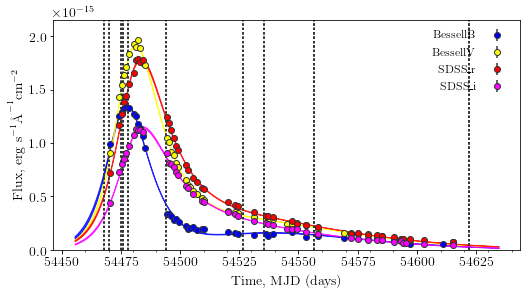

In [5]:
snname = "SN2007uy"

sn = pcc.SNClass(snname)

phot_path = os.path.join(coco_root_path, "data/lc/", snname + ".dat")
speclist_path = os.path.join(str(coco_root_path),"lists/" + snname + ".list")
recon_filename = os.path.abspath(os.path.join(str(coco_root_path), "recon/", snname + ".dat"))

print(phot_path)
sn.load_phot(path = phot_path)
# sn.phot.plot()
sn.get_lcfit(recon_filename)

sn.load_list(path = speclist_path)
sn.load_spec()
# sn.load_mangledspec()
# sn.plot_spec()
# sn.plot_mangledspec()
# sn.plot_lc(multiplot = False, mark_spectra=True, savepng=True, outpath = "/Users/berto/projects/LSST/SN2007uy")
sn.plot_lc(multiplot = False, mark_spectra=True)

In [6]:
# sn.plot_lc(multiplot = True, lock_axis=True)

In [7]:
sn.load_mangledspec()
# sn.plot_spec()

/Users/berto/Code/verbose-enigma/pycoco/classes.py:219: UserWarning: WARNING: You passed something that was <class 'numpy.str_'>This might go wrong.
  StringWarning(filename)


In [8]:
# sn.plot_mangledspec()

In [9]:
# for i in zip(sn.spec, sn.mangledspec):
#     print(i)
#     pcc.compare_spec(sn.spec[i[0]], sn.mangledspec[i[1]], normalise=True)

In [10]:
# pcc.plot_mangle(sn.spec["2009jf_-7.64.txt"], sn.mangledspec["SN2009jf_55114.060000.spec"])

In [11]:
from scipy.integrate import simps

def calc_spectrum_filter_flux(filter_name, SpecClass):
    filter_object = pcc.load_filter("/Users/berto/Code/CoCo/data/filters/" + filter_name + ".dat")
    filter_object.resample_response(new_wavelength = SpecClass.wavelength)
    filter_area = simps(filter_object.throughput, filter_object.wavelength)
    
    transmitted_spec = filter_object.throughput * SpecClass.flux

    integrated_flux = simps(transmitted_spec, SpecClass.wavelength)
    
    return  integrated_flux/filter_area

def calc_specphot(sn, filtername):

    specphot = np.array([])
    specepoch = np.array([])

    for spec in sn.mangledspec:
        specphot = np.append(specphot, calc_spectrum_filter_flux(filtername, sn.mangledspec[spec]))
        specepoch = np.append(specepoch, sn.mangledspec[spec].mjd_obs)
    
    return specepoch, specphot

def compare_phot_specphot(sn, filtername):
    """"""
    specepoch, specphot =  calc_specphot(sn, filtername)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(specepoch, specphot, label = "specphot")
    ax.scatter(sn.phot.data[filtername]["MJD"], sn.phot.data[filtername]["flux"], label = filtername)

    ax.set_ylim(0, 1.05 * np.nanmax(np.append(sn.phot.data[filtername]["flux"], specphot)))
    ax.legend()
#     plt.show()

In [12]:
# compare_phot_specphot(sn, "BessellB")
# compare_phot_specphot(sn, "BessellV")
# compare_phot_specphot(sn, "SDSS_r")
# compare_phot_specphot(sn, "SDSS_i")


inputs:

* **`snname`**
* **`redshift`**
* **`absmag offset`**
* **`EBV MW`**
* **`EBV Host`**
* **`Rv`**
* **`MJD at Peak`**

* **`MJD to simulate`**
* **`filters to simulate`**

In [13]:
sn.lcfit.get_fit_splines()

Quick check that the fit spline fits the fit (in Bessell V).
Note: spline sampled at MJDOBS so looks slightly linear.

In [14]:
# plt.plot(sn.phot.data["BessellV"]["MJD"], sn.lcfit.spline["BessellV"](sn.phot.data["BessellV"]["MJD"]), label = r"$\textnormal{Spline}$")
# plt.scatter(sn.phot.data["BessellV"]["MJD"], sn.phot.data["BessellV"]["flux"], label = r"$\textnormal{Photometry}$")
# plt.plot(sn.lcfit.data["BessellV"]["MJD"], sn.lcfit.data["BessellV"]["flux"], label = r"$\textnormal{Fit}$")
# plt.legend()

In [15]:
mjdmax = get_mjdmax_BessellV(sn)[0]

filters_to_sim = convert_column_string_encoding(sn.phot.phot["filter"]).data
mjd_to_sim = sn.phot.phot["MJD"].data

In [16]:
verbose = False
# verbose = True
for i, f in enumerate(filters_to_sim):
    filters_to_sim[i] = f.replace(b"SDSS", b"LSST").replace(b"BessellV", b"LSST_g")
#     filters_to_sim[i] = pcc.utils.b(str(f).replace("BessellV", "LSST_g").replace("SDSS_r", "LSST_r")) 
if verbose:
    print(mjdmax)
    print(mjd_to_sim)
    print(filters_to_sim)

In [17]:
# tablepath = "/Users/berto/Code/verbose-enigma/testdata/info/info.dat"

# info = Table.read(tablepath, format = "ascii.commented_header")
info = pcc.load_info()

In [18]:
z_obs = info.get_sn_info("SN2007uy")["z_obs"]
m = sfdmap.SFDMap()

print(z_obs)

z_obs
-----
0.007


In [19]:
reload(pccsims)
coco = pccsims.pyCoCo(pcc.utils.b(filter_path), pcc.utils.b(coco_root_path))

# flux, flux_err = coco.simulate(b"SN2009jf", 
#                     0.008, 0.0, 0.0, 0.0, 3.1, 
#                     mjdmax, mjd_to_sim, 
#                     filters_to_sim)

flux, flux_err = coco.simulate(b"SN2007uy", 
                    z_obs, 0.0, 0.0, 0.0, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)

# flux, flux_err = coco.simulate(b"SN2009jf", 
#                     0.008, 0.0, 0.1, 0.1, 3.1, 
#                     mjdmax, mjd_to_sim, 
#                     filters_to_sim)

In [20]:
coco.get_fit_params()

[1.6398826835888276, 3.185542695462083, 16.037053690331255, 3.0586218649062857]

In [ ]:
specphot = coco.spec_photometry(b"SN2007uy", 
                    z_obs, b"LSST_g")

# plt.scatter(specphot[0], specphot[1])
# plt.ylim(0, 1.02 *np.nanmax(specphot[1]))


In [ ]:
p = pcc.PhotometryClass()

p.load_table(pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim))

# plt.scatter(p.data["BessellV"]["MJD"], p.data["BessellV"]["flux"], label = "Synthetic Bessell V")
plt.scatter(p.data["LSST_g"]["MJD"], p.data["LSST_g"]["flux"], label = "Synthetic LSST g")
plt.scatter(sn.phot.data["BessellV"]["MJD"], sn.phot.data["BessellV"]["flux"], label = "Real Bessell V")
plt.scatter(specphot[0] + mjdmax, specphot[1])

plt.ylim(0, 1.02 *np.nanmax(np.append(p.data["LSST_g"]["flux"], sn.phot.data["BessellB"]["flux"])))
plt.legend()

In [ ]:
# p.plot()

In [ ]:
# p.save(filename = "SN2007uy_sim_LSST.dat", path = "/Users/berto/projects/LSST/cadence/")

In [ ]:
sn_fake = pcc.SNClass("SN2007uy_sim")

sn_fake.load_phot(path = "/Users/berto/projects/LSST/cadence/SN2007uy_sim_LSST.dat")
sn_fake.plot_lc(multiplot = False)

In [ ]:
from matplotlib.ticker import MultipleLocator

# filters = ["BessellV"]
filters = ["SDSS_r"]

alpha = 1.0
xminorticks = 10

pcc.setup_plot_defaults()

fig = plt.figure(figsize=[8, 4])
fig.subplots_adjust(left = 0.1, bottom = 0.13, top = 0.93,
                right = 0.91, hspace=0, wspace = 0)
## Label the axes
xaxis_label_string = r'$\textnormal{Time, MJD (days)}$'
yaxis_label_string = r'$\textnormal{Flux, erg s}^{-1}\textnormal{\AA}^{-1}\textnormal{cm}^{-2}$'

ax1 = fig.add_subplot(111)
axes_list = [ax1]

for filter_key in filters:
    plot_label_string = r'$\rm{' + sn.phot.data_filters[filter_key].filter_name.replace('_', '\\_') + '}$'
    plot_label_string_fake = r'$\rm{' + sn_fake.phot.data_filters[filter_key].filter_name.replace('_', '\\_') + ', simulated}$'

    ax1.errorbar(sn.phot.data[filter_key]['MJD'], sn.phot.data[filter_key]['flux'],
                 yerr = sn.phot.data[filter_key]['flux_err'],
                 capsize = 0, fmt = 'x', color = sn.phot.data_filters[filter_key]._plot_colour,
                 label = plot_label_string, ecolor = pcc.hex['batman'], mec = pcc.hex["batman"],
                 alpha = alpha)
    ax1.fill_between(sn.lcfit.data[filter_key]['MJD'], sn.lcfit.data[filter_key]['flux_upper'], sn.lcfit.data[filter_key]['flux_lower'],
                     color = pcc.hex["batman"],
                     alpha = 0.8, zorder = 0)
    
ax1.errorbar(sn_fake.phot.data[filter_key]['MJD'], sn_fake.phot.data[filter_key]['flux'],
         yerr = sn_fake.phot.data[filter_key]['flux_err'],
#              capsize = 0, fmt = 'o', color = sn_fake.phot.data_filters[filter_key]._plot_colour,
         capsize = 0, fmt = 'o', color = pcc.hex['r'],
         label = plot_label_string_fake, ecolor = pcc.hex['batman'], mec = pcc.hex["batman"],
         alpha = alpha)
    
xminorLocator = MultipleLocator(xminorticks)
ax1.spines['top'].set_visible(True)
ax1.xaxis.set_minor_locator(xminorLocator)

plot_legend = ax1.legend(loc = 'upper right', scatterpoints = 1, markerfirst = False,
                  numpoints = 1, frameon = False, bbox_to_anchor=(1., 1.),
                  fontsize = 12.)

ax1.set_ylabel(yaxis_label_string)
ax1.set_xlabel(xaxis_label_string)

outpath = "/Users/berto/projects/LSST/cadence/SN2007uy_consistency_check_SDSS_r"

fig.savefig(outpath + ".png", format = 'png', dpi=500)


In [ ]:
from matplotlib.ticker import MultipleLocator

# filters = ["BessellV"]
filters = ["LSST_g"]

alpha = 1.0
xminorticks = 10

pcc.setup_plot_defaults()

fig = plt.figure(figsize=[8, 4])
fig.subplots_adjust(left = 0.1, bottom = 0.13, top = 0.93,
                right = 0.91, hspace=0, wspace = 0)
## Label the axes
xaxis_label_string = r'$\textnormal{Time, MJD (days)}$'
yaxis_label_string = r'$\textnormal{Flux, erg s}^{-1}\textnormal{\AA}^{-1}\textnormal{cm}^{-2}$'

ax1 = fig.add_subplot(111)
axes_list = [ax1]

for filter_key in filters:
    plot_label_string = r'$\rm{' + sn.phot.data_filters["BessellV"].filter_name.replace('_', '\\_') + '}$'
    plot_label_string_fake = r'$\rm{' + sn_fake.phot.data_filters[filter_key].filter_name.replace('_', '\\_') + ', simulated}$'

    ax1.errorbar(sn.phot.data["BessellV"]['MJD'], sn.phot.data["BessellV"]['flux'],
                 yerr = sn.phot.data["BessellV"]['flux_err'],
                 capsize = 0, fmt = 'x', color = sn.phot.data_filters["BessellV"]._plot_colour,
                 label = plot_label_string, ecolor = pcc.hex['batman'], mec = pcc.hex["batman"],
                 alpha = alpha)
    ax1.fill_between(sn.lcfit.data["BessellV"]['MJD'], sn.lcfit.data["BessellV"]['flux_upper'], sn.lcfit.data["BessellV"]['flux_lower'],
                     color = pcc.hex["batman"],
                     alpha = 0.8, zorder = 0)
    
    ax1.errorbar(sn_fake.phot.data[filter_key]['MJD'], sn_fake.phot.data[filter_key]['flux'],
             yerr = sn_fake.phot.data[filter_key]['flux_err'],
#              capsize = 0, fmt = 'o', color = sn_fake.phot.data_filters[filter_key]._plot_colour,
             capsize = 0, fmt = 'o', color = pcc.hex['LSST_g'],
             label = plot_label_string_fake, ecolor = pcc.hex['batman'], mec = pcc.hex["batman"],
             alpha = alpha)
    
xminorLocator = MultipleLocator(xminorticks)
ax1.spines['top'].set_visible(True)
ax1.xaxis.set_minor_locator(xminorLocator)

plot_legend = ax1.legend(loc = 'upper right', scatterpoints = 1, markerfirst = False,
                  numpoints = 1, frameon = False, bbox_to_anchor=(1., 1.),
                  fontsize = 12.)

ax1.set_ylabel(yaxis_label_string)
ax1.set_xlabel(xaxis_label_string)
print(ax1.get_xlim())
outpath = "/Users/berto/projects/LSST/cadence/SN2007uy_consistency_check_BessellV_LSSTg"

# fig.savefig(outpath + ".png", format = 'png', dpi=500)


In [ ]:
cadencepath = "/Users/berto/projects/LSST/cadence/LSST_DDF_2786_cadence.dat"

data = Table.read(cadencepath, format = "ascii.commented_header")
w = np.logical_or(data["filter"] == "LSST_g", data["filter"] == "LSST_r")

mjd_to_sim = data[w]["MJD"].data
filters_to_sim = convert_column_string_encoding(data[w]["filter"]).data

In [ ]:
# mjd_to_sim
mjd_to_sim = mjd_to_sim - (mjd_to_sim[0] - 54450)

In [ ]:
#
flux, flux_err = coco.simulate(b"SN2007uy", 
                    z_obs, 0.0, 0.0, 0.0, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)

In [ ]:
p = pcc.PhotometryClass()

p.load_table(pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim))


In [ ]:
p.plot()

In [ ]:
p.save(filename = "SN2007uy_sim_LSST_gr.dat", path = "/Users/berto/projects/LSST/cadence/")

In [ ]:
sn_fake = pcc.SNClass("SN2007uy_sim")

sn_fake.load_phot(path = "/Users/berto/projects/LSST/cadence/SN2007uy_sim_LSST_gr.dat")
sn_fake.plot_lc(multiplot = False)

In [ ]:
from matplotlib.ticker import MultipleLocator

filters = ["BessellV", "SDSS_r"]
markers = ["x", "o"]
# filters = ["LSST_g"]

alpha = 1.0
xminorticks = 10

pcc.setup_plot_defaults()

fig = plt.figure(figsize=[8, 4])
fig.subplots_adjust(left = 0.1, bottom = 0.13, top = 0.93,
                right = 0.91, hspace=0, wspace = 0)
## Label the axes
xaxis_label_string = r'$\textnormal{Time, MJD (days)}$'
yaxis_label_string = r'$\textnormal{Flux, erg s}^{-1}\textnormal{\AA}^{-1}\textnormal{cm}^{-2}$'

ax1 = fig.add_subplot(111)
axes_list = [ax1]

for j, filter_key in enumerate(filters):
    plot_label_string = r'$\rm{' + sn.phot.data_filters[filter_key].filter_name.replace('_', '\\_') + '}$'

    ax1.errorbar(sn.phot.data[filter_key]['MJD'], sn.phot.data[filter_key]['flux'],
                 yerr = sn.phot.data[filter_key]['flux_err'],
                 capsize = 0, fmt = markers[j], color = "none",
                 label = plot_label_string, ecolor = pcc.hex['batman'], mec = pcc.hex["batman"],
                 alpha = alpha,)
    ax1.fill_between(sn.lcfit.data[filter_key]['MJD'], sn.lcfit.data[filter_key]['flux_upper'], sn.lcfit.data[filter_key]['flux_lower'],
                     color = pcc.hex["batman"],
                     alpha = 0.8, zorder = 0)

fake_filters = ["LSST_g", "LSST_r"]
for j, filter_key in enumerate(fake_filters):
    plot_label_string_fake = r'$\rm{' + sn_fake.phot.data_filters[filter_key].filter_name.replace('_', '\\_') + ', simulated}$'
    
    ax1.errorbar(sn_fake.phot.data[filter_key]['MJD'], sn_fake.phot.data[filter_key]['flux'],
             yerr = sn_fake.phot.data[filter_key]['flux_err'],
             capsize = 0, fmt = 'o', color = sn_fake.phot.data_filters[filter_key]._plot_colour,
#              capsize = 0, fmt = 'o', color = pcc.hex['LSST_g'],
             label = plot_label_string_fake, ecolor = pcc.hex['batman'], mec = pcc.hex["batman"],
             alpha = alpha)
    
xminorLocator = MultipleLocator(xminorticks)
ax1.spines['top'].set_visible(True)
ax1.xaxis.set_minor_locator(xminorLocator)

plot_legend = ax1.legend(loc = 'upper right', scatterpoints = 1, markerfirst = False,
                  numpoints = 1, frameon = False, bbox_to_anchor=(1., 1.),
                  fontsize = 12.)

ax1.set_ylabel(yaxis_label_string)
ax1.set_xlabel(xaxis_label_string)

ax1.set_xlim(ax1.get_xlim()[0], 54643.724999999999 )
outpath = "/Users/berto/projects/LSST/cadence/SN2007uy_cadence_check_LSSTr_LSSTg"

fig.savefig(outpath + ".png", format = 'png', dpi=500)


In [ ]:
# flux

In [ ]:
# pccsims.__file__

In [ ]:
# p.plot(["Bessellv"], legend=True)

In [ ]:
sn.plot_lc(["BessellV"], multiplot = False)
plt.scatter(p.data["BessellV"]["MJD"], p.data["BessellV"]["flux"], label = "Synthetic Bessell V")


In [ ]:
p.plot(["BessellB"])

In [ ]:
sn.plot_lc(multiplot=False)

In [ ]:
sn.load_mangledspec()

In [ ]:
sn.plot_mangledspec()

In [ ]:
sn.plot_spec()

In [ ]:
mjdmax = get_mjdmax_BessellV(sn)[0]

filters_to_sim = convert_column_string_encoding(sn.phot.data["BessellB"]["filter"]).data
mjd_to_sim = sn.phot.data["BessellB"]["MJD"].data

flux, flux_err = coco.simulate(b"SN2009jf", 
                    z_obs, -0.0, 0.2, 0.3, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)

In [ ]:
plt.scatter(mjd_to_sim,sn.phot.data["BessellB"]["flux"])
plt.plot(sn.lcfit.data["BessellB"]["MJD"], sn.lcfit.data["BessellB"]["flux"])

plt.ylim(0, np.nanmax(sn.phot.data["BessellB"]["flux"])*1.1)

In [ ]:
p = pcc.PhotometryClass()

p.load_table(pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim))

In [ ]:
p.plot()

In [ ]:
# s = pcc.SpectrumClass()

# s.load("SN2009jf_55106.120000.spec", directory="/Users/berto/Code/CoCo/spectra/")

# s.plot()

In [ ]:
# s = pcc.SpectrumClass()
# s.load("SN2009jf_55108.130000.spec", directory="/Users/berto/Code/CoCo/spectra/")
# s.plot()

In [ ]:
# s = pcc.SpectrumClass()
# s.load("SN2009jf_55114.060000.spec", directory="/Users/berto/Code/CoCo/spectra/")
# s.plot()

In [ ]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table
def load_coords(filename = "sncoordinates.list"):
    """

    """
    path = os.path.abspath(os.path.join(pcc.__path__[0], os.path.pardir, filename))
    coordtable = Table.read(path, format = 'ascii.commented_header')
    return coordtable

In [ ]:
# %timeit load_coords()

In [ ]:
cootable = load_coords()

In [ ]:
%%timeit

snname = "SN2009jf"
w = np.where(cootable["snname"] == snname)
c = SkyCoord(cootable["RA"][w], cootable["Dec"][w], frame='icrs')


In [ ]:
c.ra.deg[0], c.dec.deg[0]

In [ ]:
import sfdmap

In [ ]:
m = sfdmap.SFDMap()

In [ ]:
m.ebv(c.ra.deg[0], c.dec.deg[0], unit = 'degree')